<a href="https://colab.research.google.com/github/Saadman53/Thesis-Human-Activity-Recognition/blob/main/(UTD)_CNN_on_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
gdrive_path = "drive/My Drive/Dataset/UTD MHAD/utd_mhad_sobel.mat"
sensor_path ="drive/My Drive/Dataset/UTD MHAD/utd_sensor_features_acc_gyro.mat"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install ax-platform

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time


from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data

from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import torch.optim as optim
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render
from ax.utils.tutorials.cnn_utils import train, evaluate


import torchvision
import torchvision.transforms as transforms



import random
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report


from torch.utils.data import DataLoader, ConcatDataset
# from torchvision import transforms
from sklearn.model_selection  import StratifiedKFold

import torch.optim.lr_scheduler as lr_scheduler
%matplotlib inline

import scipy.io as sio
torch.autograd.set_detect_anomaly(True)


from functools import partial
from typing import Any, Optional

import torch
import torch.nn as nn

In [4]:
dat = sio.loadmat(gdrive_path)

In [5]:
X = dat['sobel'][0][1]
y = dat['sobel'][0][5].ravel()
files = dat['sobel'][0][4].ravel()

In [6]:
data_transforms = transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((256),interpolation=transforms.InterpolationMode.BILINEAR),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [7]:
data = []
for x in X:
  t = torch.from_numpy(x.astype(np.float32)).reshape((1,227,227))
  t = t.expand(3,*t.shape[1:])
  t = data_transforms(t)
  t = t.numpy()
  data.append(t)
data = np.array(data)

In [8]:
files = [x.replace("_depth.mat","") for x in files ]
files = [x.replace(" ","") for x in files]
samples = data.shape[0]
map_filename_data = dict(zip(files, data))
map_filename_label = dict(zip(files, y.ravel()))
sensor_Dat = sio.loadmat(sensor_path)
train_files = [x[0].replace("_inertial.mat","") for x in sensor_Dat['train_filename'].ravel()]
test_files = [x[0].replace("_inertial.mat","") for x in sensor_Dat['test_filename'].ravel()]
train_X = []
train_y = []
test_X = []
test_y = []

for file in train_files:
  train_X.append(map_filename_data[file])
  train_y.append(map_filename_label[file])

for file in test_files:
  test_X.append(map_filename_data[file])
  test_y.append(map_filename_label[file])

X_train = np.array(train_X)
X_test = np.array(test_X)
y_train = np.array(train_y)-1
y_test = np.array(test_y)-1

In [35]:
conv1 = nn.Conv2d(1,6,5)
pool = F.avg_pool2d
conv2 = nn.Conv2d(6,16,5)

In [ ]:
for x in 

torch.Size([3, 224, 224])

In [71]:
conv1 = nn.Conv2d(3,6,5)
relu = nn.ReLU()
max_pool = nn.MaxPool2d(2,2)
conv2 = nn.Conv2d(6,16,5)
avg_pool = F.avg_pool2d

In [62]:
conv1(x).shape

torch.Size([6, 220, 220])

In [66]:
max_pool(relu(conv1(x))).shape

torch.Size([6, 110, 110])

In [68]:
conv2(max_pool(relu(conv1(x)))).shape

torch.Size([16, 106, 106])

In [69]:
max_pool(relu(conv2(max_pool(relu(conv1(x)))))).shape

torch.Size([16, 53, 53])

In [73]:
avg_pool(max_pool(relu(conv2(max_pool(relu(conv1(x)))))),2).shape

torch.Size([16, 26, 26])

In [12]:
class CNN(nn.Module):
    def __init__(self,output_size):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.max_pool = nn.MaxPool2d(2,2)
        self.avg_pool = F.avg_pool2d
        self.conv2 = nn.Conv2d(6,16,5)
        # self.hidden1 = nn.Linear(16*6*6,2048)
        # self.hidden2 = nn.Linear(2048,1024)
        # self.hidden3 = nn.Linear(1024,512)
        self.hidden3 = nn.Linear(16*26*26,512)
        self.hidden4 = nn.Linear(512,256)
        self.hidden5 = nn.Linear(256,128)
        self.hidden6 = nn.Linear(128,64)
        self.output = nn.Linear(64,output_size)
        self.softmax = F.softmax
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)
        self.batchnorm1 = nn.BatchNorm1d(2048)
        self.batchnorm2 = nn.BatchNorm1d(1024)
        self.batchnorm3 = nn.BatchNorm1d(512)
        self.batchnorm4 = nn.BatchNorm1d(256)
        self.batchnorm5 = nn.BatchNorm1d(128)
        self.batchnorm6 = nn.BatchNorm1d(64)
    
    def forward(self,x):
        out = self.max_pool(self.relu(self.conv1(x)))
        out = self.max_pool(self.relu(self.conv2(out)))
        #print(out.shape)
        out = self.avg_pool(out, 2,2)
        #print(out.shape)
        out = out.view(-1, 16*26*26)
        out = self.hidden3(out)
        out = self.batchnorm3(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.hidden4(out)
        out = self.batchnorm4(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.hidden5(out)
        out = self.batchnorm5(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.hidden6(out)
        out = self.batchnorm6(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.output(out)
        return out

In [13]:
def extract_batch(X,y,batch_size,step,no_of_samples):
  l = (step-1)*batch_size
  return X[l:(l+batch_size)],y[l:min(no_of_samples,l+batch_size)]
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)   
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum()*1.0 / len(correct_pred)
    acc = acc * 100
    return acc

In [14]:
def plot_confusion_matrix(net, test_X, test_y):
  y_pred = net(test_X)
  y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
  _, y_pred = torch.max(y_pred_softmax, dim = 1)   
  y_pred = y_pred.detach().numpy().ravel()
  cm = confusion_matrix(test_y.ravel(), y_pred)
  #tn, fp, fn, tp = cm.ravel()
  recall = np.mean(recall_score(test_y.ravel(), y_pred, average=None))*100.0
  precision = np.mean(precision_score(test_y.ravel(), y_pred, average=None))*100.0
  f,ax=plt.subplots(figsize=(20,10))
  sns.heatmap(cm,annot=True,fmt='.0f', cmap="Blues")
  plt.ylabel('Actual Values')
  plt.xlabel('Predicted Values')
  plt.show()
  return cm, y_pred,recall, precision

In [17]:
def model_training_evaluation(X_train, X_test, y_train, y_test):
  train_X = torch.from_numpy(X_train.astype(np.float32))
  test_X = torch.from_numpy(X_test.astype(np.float32))
  train_y =  torch.tensor(y_train)
  test_y =  torch.tensor(y_test)
  output_size = torch.unique(train_y).shape[0]
  num_epochs = 100
  n_samples = train_X.shape[0]
  criterion = nn.CrossEntropyLoss(reduction='sum')
  best_lr = None
  best_loss = 100000
  best_model = None
  best_train_loss = None
  best_val_loss = None
  best_epoch = None
  skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)
  for lr in [0.01]:
    #print(f"Learning rate: {lr}:")
    cnt = 1
    figure, ax = plt.subplots(3,figsize=(12,8))
    figure.tight_layout()
    #model definition
    for train_index, val_index in skf.split(X_train, y_train):
      net = CNN( output_size)
      optimizer = torch.optim.SGD(net.parameters(), lr=lr) 
      #scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
      train_X_fold = train_X[train_index]
      train_y_fold = train_y[train_index]
      val_x_fold = train_X[val_index]
      val_y_fold = train_y[val_index]
      n_samples = train_X_fold.shape[0]
      batch_size = int(n_samples/5)
      train_loss = []
      val_loss = []
      print(f"Training for fold {cnt}")
      for epoch in range(num_epochs):
        step = 1
        while(batch_size*step<=n_samples):
          x,y =  extract_batch(train_X_fold,train_y_fold, batch_size, step, n_samples)
          # Forward Propagation
          y_predicted = net(x)
          #print(batch_size,y_predicted.shape, y.shape)
          loss = criterion(y_predicted,  torch.tensor(y, dtype=torch.long))
          # Backward propagation and update
          loss.backward()
          optimizer.step()
          # Performing zero grad before new step
          optimizer.zero_grad()
          step = step+1
        #scheduler.step()
        t_loss = criterion( net(train_X_fold),  torch.tensor(train_y_fold, dtype=torch.long)).item()/train_X_fold.shape[0]
        v_loss = criterion( net(val_x_fold),  torch.tensor(val_y_fold, dtype=torch.long)).item()/val_x_fold.shape[0]
        train_loss.append(t_loss) 
        val_loss.append(v_loss)
        print(f"Epoch {epoch+1} completed. Validation loss: {v_loss}")
        if(v_loss<best_loss):
          best_lr = lr
          best_loss = v_loss
          best_model = net
          best_epoch = epoch
      #print(f"Learning Rate: {scheduler.get_last_lr()}")
      m = "Fold "+str(cnt)
      ax[cnt-1].title.set_text(m)
      ax[cnt-1].set_ylabel("Total Loss")
      ax[cnt-1].set_xlabel("No of Epochs")
      ax[cnt-1].plot(range(num_epochs),train_loss, label = "train loss")
      ax[cnt-1].plot(range(num_epochs),val_loss, label = "validation loss")
      cnt+=1
  y_pred = best_model(test_X)
  acc = multi_acc(y_pred, test_y)
  cm, pred,recall, precision = plot_confusion_matrix(best_model, test_X, y_test)
  print(f"Accuracy is {(acc):.2f}%")
  print(f"Recall is {(recall):.2f}%")
  print(f"Precision is {(precision):.2f}%")


Training for fold 1
Epoch 1 completed. Validation loss: 2.922574166839701
Epoch 2 completed. Validation loss: 2.529205018103717
Epoch 3 completed. Validation loss: 2.1962286356675667
Epoch 4 completed. Validation loss: 2.029494580240345
Epoch 5 completed. Validation loss: 1.7362853395582434
Epoch 6 completed. Validation loss: 1.7216533268012875
Epoch 7 completed. Validation loss: 1.556219563531717
Epoch 8 completed. Validation loss: 1.7279401506696428
Epoch 9 completed. Validation loss: 1.5594293841491902
Epoch 10 completed. Validation loss: 1.469533622462884
Epoch 11 completed. Validation loss: 1.6296953473772322
Epoch 12 completed. Validation loss: 1.5359588318884967
Epoch 13 completed. Validation loss: 1.292107566250519
Epoch 14 completed. Validation loss: 1.5032597031704216
Epoch 15 completed. Validation loss: 1.4896028334912272
Epoch 16 completed. Validation loss: 1.4798058798146803
Epoch 17 completed. Validation loss: 1.585366283936358
Epoch 18 completed. Validation loss: 1.61562

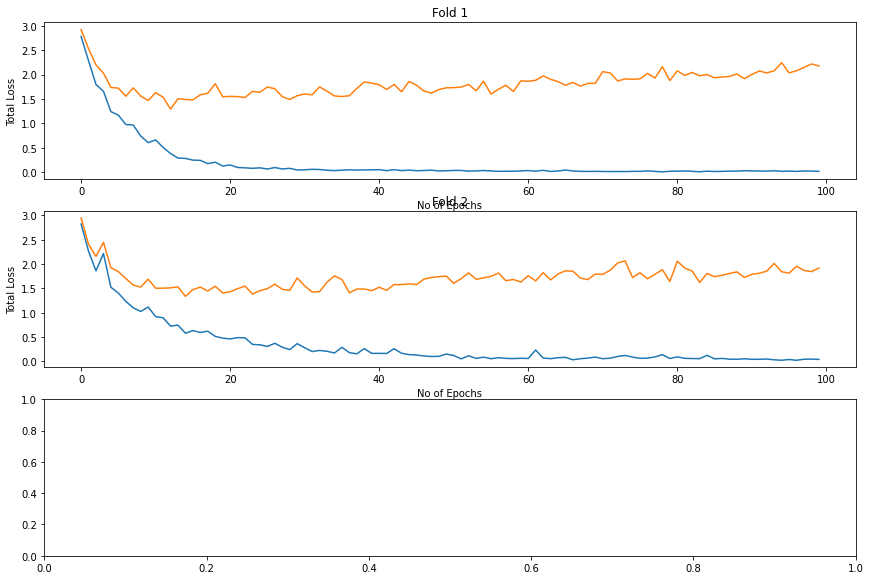

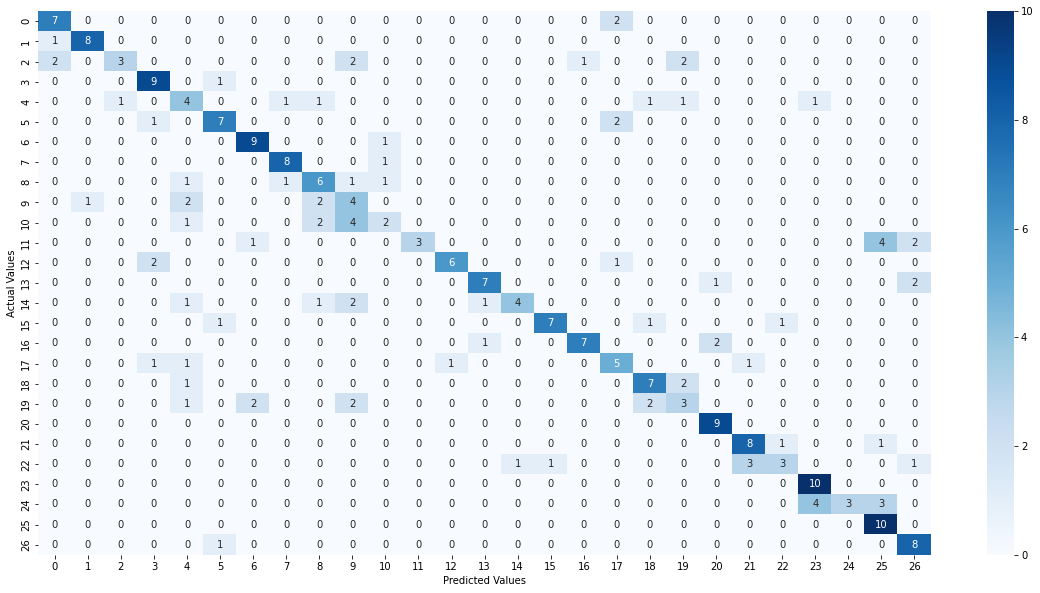

Accuracy is 65.25%
Recall is 64.49%
Precision is 67.90%


In [18]:
model_training_evaluation(X_train, X_test, y_train, y_test)